# CAPM Analysis Explained

## Understanding CAPM (Capital Asset Pricing Model)

CAPM is a financial model that calculates the expected return of an investment based on:

- Its sensitivity to market movements (Beta) 
- The risk-free rate
- The expected market return

## Formula: 

`Expected Return = Risk-Free Rate + Beta × (Market Return - Risk-Free Rate)`

---

## 1. Import Required Libraries

In [16]:
import pandas as pd
import yfinance as yf
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio  # Added for renderer control
from IPython.display import display, HTML  # For alternative display

# Set Plotly renderer to PNG to avoid nbformat issues
pio.renderers.default = 'png'
print(f"Plotly will use renderer: {pio.renderers.default}")

Plotly will use renderer: png


---

## 2. Fetch Stock Data

Let's pick two stocks to analyze:  **Apple (AAPL)** and **Microsoft (MSFT)** 
We'll compare them against the **S&P 500** market index.

In [17]:
# Define our stocks and time period
tickers = ["AAPL", "MSFT", "^GSPC"]  # Include SP500 in the same download
start_date = "2023-01-01"
end_date = "2024-01-01"

# Download all data at once
print("Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

print(f"\nData columns structure: {data.columns}")
print(f"\nData shape: {data.shape}")

# Check if download was successful
if data.empty:
    print("❌ ERROR: No data downloaded. Check your internet connection and ticker symbols.")
    print("Trying alternative approach...")
    # Alternative: Download each ticker separately
    data_dict = {}
    for ticker in tickers:
        try:
            ticker_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
            if not ticker_data.empty:
                data_dict[ticker] = ticker_data['Close']
                print(f"✓ Downloaded {ticker}")
        except Exception as e:
            print(f"✗ Failed to download {ticker}: {e}")
    
    if data_dict:
        close_prices = pd.DataFrame(data_dict)
        close_prices.columns = ['AAPL', 'MSFT', 'SP500']
    else:
        raise ValueError("Could not download any data. Please check your internet connection.")
else:
    # Original approach if download succeeded
    pass


Data columns structure: MultiIndex([( 'Close',  'AAPL'),
            ( 'Close',  'MSFT'),
            ( 'Close', '^GSPC'),
            (  'High',  'AAPL'),
            (  'High',  'MSFT'),
            (  'High', '^GSPC'),
            (   'Low',  'AAPL'),
            (   'Low',  'MSFT'),
            (   'Low', '^GSPC'),
            (  'Open',  'AAPL'),
            (  'Open',  'MSFT'),
            (  'Open', '^GSPC'),
            ('Volume',  'AAPL'),
            ('Volume',  'MSFT'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])

Data shape: (250, 15)


/var/folders/vj/t_c682y12pvbvcx2rm5j6nk40000gn/T/ipykernel_4445/761820166.py:8: FutureWarning:

YF.download() has changed argument auto_adjust default to True



---

## 3. Prepare and Explore the Data

Let's look at the raw stock prices:

In [18]:
# Access the 'Close' prices (auto_adjust=True gives adjusted closes)
if 'data' in locals() and not data.empty:
    if isinstance(data.columns, pd.MultiIndex):
        close_prices = data['Close']
        # Rename ^GSPC to SP500 for clarity
        close_prices.columns = ['AAPL', 'MSFT', 'SP500']
    else:
        close_prices = pd.DataFrame(data['Close'], columns=['AAPL', 'MSFT', 'SP500'])

# Reset index to make Date a regular column
close_prices = close_prices.reset_index()

# Check for missing values
print("Checking for missing values...")
missing_values = close_prices.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() > 0:
    print("\n⚠️ Missing values detected. Filling with forward fill...")
    close_prices = close_prices.fillna(method='ffill').fillna(method='bfill')

# Show first few rows
print("\n" + "="*50)
print("Stock Price Data (First 5 rows):")
print(close_prices.head())

print("\nData Info:")
print(close_prices.info())

print("\nBasic Statistics:")
print(close_prices[['AAPL', 'MSFT', 'SP500']].describe())

Checking for missing values...
Series([], dtype: int64)

Stock Price Data (First 5 rows):
        Date        AAPL        MSFT        SP500
0 2023-01-03  123.211205  233.985657  3824.139893
1 2023-01-04  124.482040  223.750381  3852.969971
2 2023-01-05  123.161942  217.118927  3808.100098
3 2023-01-06  127.693565  219.677704  3895.080078
4 2023-01-09  128.215698  221.816574  3892.090088

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    250 non-null    datetime64[ns]
 1   AAPL    250 non-null    float64       
 2   MSFT    250 non-null    float64       
 3   SP500   250 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.9 KB
None

Basic Statistics:
             AAPL        MSFT        SP500
count  250.000000  250.000000   250.000000
mean   170.510817  308.139015  4283.729439
std     17.340363 

### What we just did:

- Downloaded daily closing prices for AAPL, MSFT, and S&P 500 in one call
- With auto_adjust=True (default), 'Close' prices are already adjusted for dividends/splits
- Renamed ^GSPC to SP500 for clarity
- Converted the index to a regular Date column
- Handled missing values

---

## 4. Normalize Prices for Comparison

When stocks have different price levels, we normalize them to start at 1.0 for easy comparison:

In [19]:
def normalize_prices(df):
    """
    Normalize all price columns to start at 1.0
    This makes comparing performance easier
    """
    normalized = df.copy()
    for column in df.columns:
        if column != 'Date':
            # Check if column has data
            if normalized[column].isnull().all():
                print(f"Warning: Column {column} has no data")
                continue
            normalized[column] = normalized[column] / normalized[column].iloc[0]
    return normalized

# Apply normalization
normalized_data = normalize_prices(close_prices)

print("Normalized Prices (First 5 rows):")
print(normalized_data.head())

# Check normalization worked
print("\nChecking normalization (should all be 1.0 at start):")
for col in ['AAPL', 'MSFT', 'SP500']:
    if col in normalized_data.columns:
        start_val = normalized_data[col].iloc[0]
        print(f"{col}: {start_val:.6f} (Expected: 1.0)")

Normalized Prices (First 5 rows):
        Date      AAPL      MSFT     SP500
0 2023-01-03  1.000000  1.000000  1.000000
1 2023-01-04  1.010314  0.956257  1.007539
2 2023-01-05  0.999600  0.927916  0.995806
3 2023-01-06  1.036379  0.938851  1.018551
4 2023-01-09  1.040617  0.947992  1.017769

Checking normalization (should all be 1.0 at start):
AAPL: 1.000000 (Expected: 1.0)
MSFT: 1.000000 (Expected: 1.0)
SP500: 1.000000 (Expected: 1.0)


### Why normalize?

- AAPL might be at $180, MSFT at $380, S&P 500 at 4500
- By dividing by their starting values, we see percentage changes clearly
- All lines start at 1.0, making comparison visual and intuitive

---

## 5. Visualize Normalized Performance

Displaying plot as static PNG image...
Error displaying plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


Alternative display method...


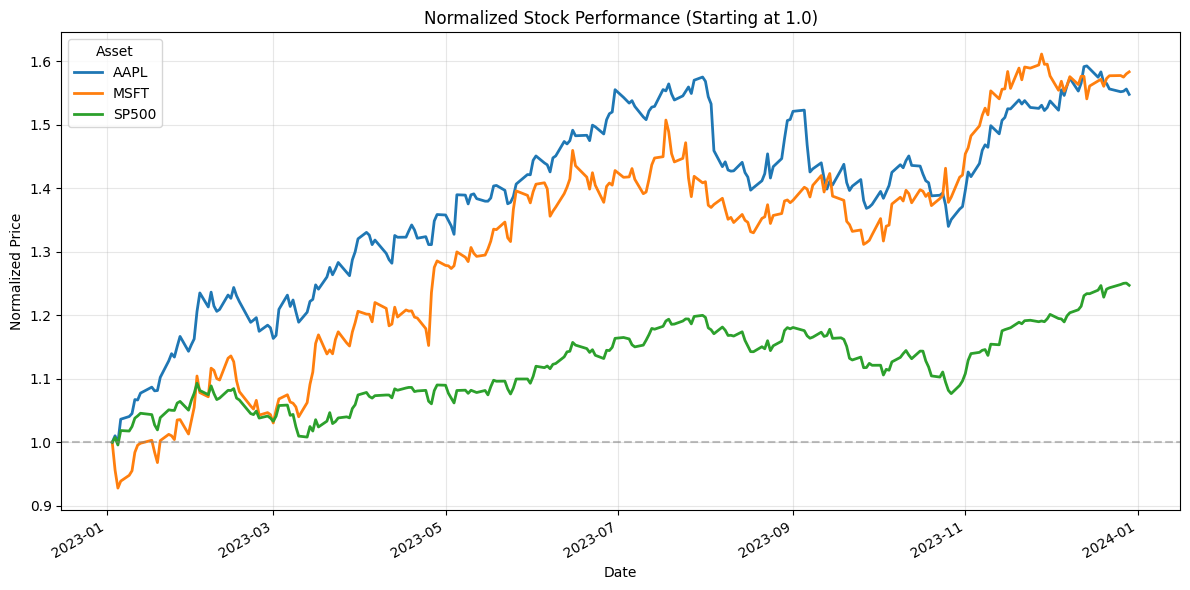

In [20]:
# Create an interactive plot - FIXED VERSION
fig = px.line(normalized_data, 
              x='Date', 
              y=['AAPL', 'MSFT', 'SP500'],
              title="Normalized Stock Performance (Starting at 1.0)",
              labels={'value': 'Normalized Price', 'variable': 'Asset'})

# Customize the plot
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Price (Normalized to 1.0)",
    hovermode='x unified',
    template='plotly_white',
    legend_title="Asset",
    height=500
)

# Add horizontal line at 1.0 for reference
fig.add_hline(y=1.0, line_dash="dash", line_color="gray", opacity=0.5)

# FIXED DISPLAY METHOD
print("Displaying plot as static PNG image...")
try:
    # Method 1: Display as static image (always works)
    fig.show(renderer="png")
    
    # Method 2: Also save to HTML for interactive viewing
    fig.write_html("normalized_performance.html")
    print("\n✅ Interactive version saved as 'normalized_performance.html'")
    print("   Open this file in your web browser for full interactivity.")
    
except Exception as e:
    print(f"Error displaying plot: {e}")
    print("\nAlternative display method...")
    
    # Fallback: Use matplotlib
    plt.figure(figsize=(12, 6))
    for column in ['AAPL', 'MSFT', 'SP500']:
        if column in normalized_data.columns:
            plt.plot(normalized_data['Date'], normalized_data[column], label=column, linewidth=2)
    
    plt.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Normalized Stock Performance (Starting at 1.0)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend(title='Asset')
    plt.grid(True, alpha=0.3)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

### What this shows:

- All stocks start at the same point (1.0)
- The slope indicates performance: steeper = better returns
- You can easily see which stock outperformed the market (S&P 500)
- The market (SP500) serves as our benchmark

--- 

## 6. Calculate Daily Returns

For CAPM, we need daily percentage returns, not prices:

In [21]:
def calculate_daily_returns(df):
    """
    Calculate daily percentage returns
    Formula: (Today's Price - Yesterday's Price) / Yesterday's Price
    """
    returns = df.copy()
    
    # Make sure we have the Date column
    if 'Date' not in returns.columns:
        print("Warning: 'Date' column not found. Using index instead.")
        returns = returns.reset_index()
    
    # Set Date as index for pct_change
    returns.set_index('Date', inplace=True)
    
    # Calculate percentage change for all columns
    returns = returns.pct_change() * 100
    
    # Reset index to bring Date back as column
    returns = returns.reset_index()
    
    # Remove first row (no return data)
    returns = returns.dropna().reset_index(drop=True)
    
    return returns

# Calculate returns
print("Calculating daily returns...")
daily_returns = calculate_daily_returns(close_prices)

print("Daily Returns (First 5 rows):")
print(daily_returns.head())

print("\nAverage Daily Returns (%):")
avg_returns = daily_returns[['AAPL', 'MSFT', 'SP500']].mean()
print(avg_returns.round(3))

print("\nNumber of trading days with returns:", len(daily_returns))

Calculating daily returns...
Daily Returns (First 5 rows):
        Date      AAPL      MSFT     SP500
0 2023-01-04  1.031429 -4.374317  0.753897
1 2023-01-05 -1.060473 -2.963773 -1.164553
2 2023-01-06  3.679403  1.178514  2.284078
3 2023-01-09  0.408895  0.973640 -0.076763
4 2023-01-10  0.445640  0.761727  0.697823

Average Daily Returns (%):
AAPL     0.183
MSFT     0.197
SP500    0.092
dtype: float64

Number of trading days with returns: 249


### Daily Returns Interpretation:

- Positive values: Asset went up that day
- Negative values: Asset went down that day
- Larger absolute values: More volatility
- Average returns show which asset performed best over the period

--- 

## 7. Calculate Beta

Beta measures a stock's sensitivity to market movements:

In [22]:
def calculate_beta(stock_returns, market_returns):
    """
    Calculate Beta using linear regression
    Beta = covariance(stock, market) / variance(market)
    """
    # Align the indices
    aligned_data = pd.DataFrame({
        'stock': stock_returns,
        'market': market_returns
    }).dropna()
    
    if len(aligned_data) < 2:
        print("Warning: Insufficient data for beta calculation")
        return np.nan
    
    # Calculate covariance and variance
    covariance = np.cov(aligned_data['stock'], aligned_data['market'])[0, 1]
    variance = np.var(aligned_data['market'])
    
    # Avoid division by zero
    if variance == 0:
        print("Warning: Market variance is zero")
        return np.nan
    
    beta = covariance / variance
    return beta

# Extract market returns (S&P 500)
market_returns = daily_returns.set_index('Date')['SP500']
stock_returns_df = daily_returns.set_index('Date')[['AAPL', 'MSFT']]

# Calculate Beta for each stock
betas = {}
print("\n" + "="*50)
print("BETA CALCULATIONS")
print("="*50)

for stock in ['AAPL', 'MSFT']:
    if stock in stock_returns_df.columns:
        beta = calculate_beta(stock_returns_df[stock], market_returns)
        betas[stock] = beta
        if not np.isnan(beta):
            print(f"Beta for {stock}: {beta:.3f}")
        else:
            print(f"Beta for {stock}: Could not calculate (insufficient data)")
    else:
        print(f"Stock {stock} not found in data")


BETA CALCULATIONS
Beta for AAPL: 1.109
Beta for MSFT: 1.184


### Beta Interpretation:

- Beta > 1: Stock is more volatile than the market (Aggressive)
- Example: Beta = 1.5 → If market moves 1%, stock tends to move 1.5%
- Beta = 1: Stock moves with the market
- Beta < 1: Stock is less volatile than the market (Defensive)
- Example: Beta = 0.7 → If market moves 1%, stock tends to move 0.7%
- Beta < 0: Stock moves opposite to the market (Very rare)

--- 

## 8. Visualize Beta with Scatter Plots

Let's create regression plots to visualize the relationship:

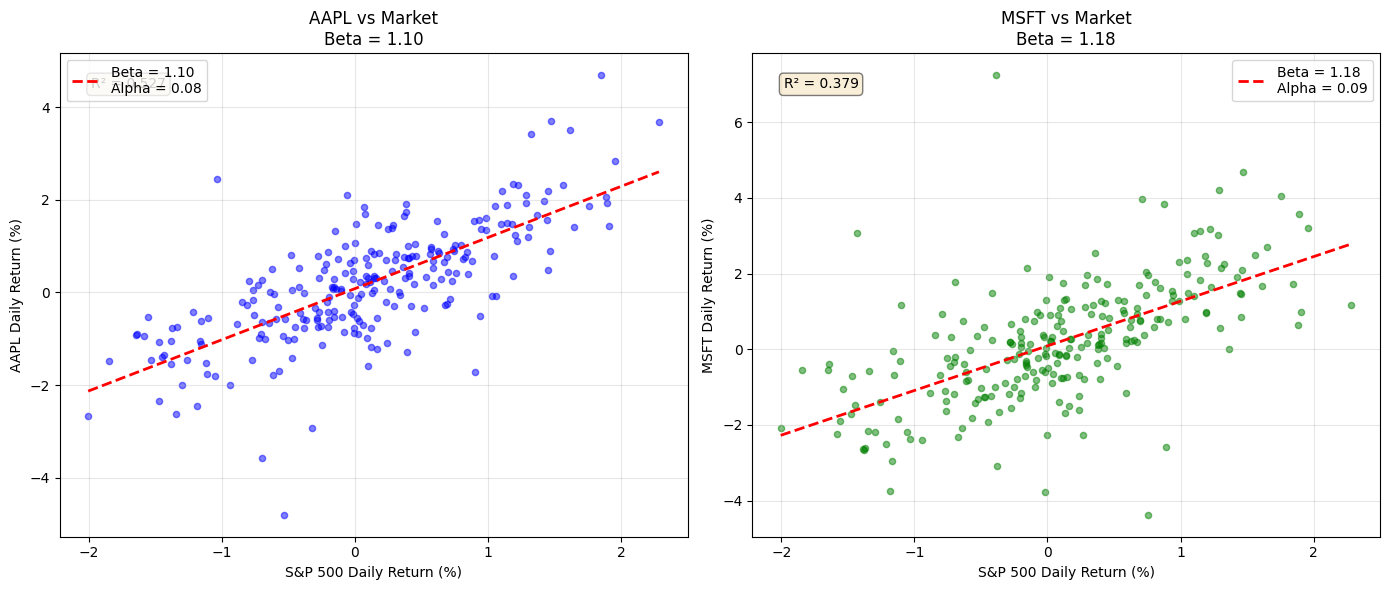

In [24]:
# Create subplots - FIXED VERSION
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

stocks = ['AAPL', 'MSFT']
colors = ['blue', 'green']

# Make sure we have data for plotting
if 'returns_for_plot' not in locals():
    returns_for_plot = daily_returns.set_index('Date')

for idx, (stock, color) in enumerate(zip(stocks, colors)):
    if stock not in returns_for_plot.columns:
        print(f"Skipping {stock} - not in data")
        continue
        
    ax = axes[idx]
    
    # Get data for this stock
    stock_data = returns_for_plot[stock]
    market_data = returns_for_plot['SP500']
    
    # Align data
    plot_data = pd.DataFrame({
        'market': market_data,
        'stock': stock_data
    }).dropna()
    
    if len(plot_data) < 2:
        ax.text(0.5, 0.5, 'Insufficient Data', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{stock} vs Market\nInsufficient Data')
        continue
    
    # Scatter plot
    ax.scatter(plot_data['market'], plot_data['stock'], 
               alpha=0.5, color=color, s=20)
    
    # Calculate regression line
    try:
        beta, alpha = np.polyfit(plot_data['market'], plot_data['stock'], 1)
        
        # Plot regression line
        x_range = np.linspace(plot_data['market'].min(), plot_data['market'].max(), 100)
        y_range = beta * x_range + alpha
        ax.plot(x_range, y_range, 'r--', linewidth=2, 
                label=f'Beta = {beta:.2f}\nAlpha = {alpha:.2f}')
        
        # Add correlation coefficient
        correlation = np.corrcoef(plot_data['market'], plot_data['stock'])[0, 1]
        r_squared = correlation ** 2
        
    except Exception as e:
        print(f"Error calculating regression for {stock}: {e}")
        beta, alpha, r_squared = np.nan, np.nan, np.nan
    
    # Labels and title
    ax.set_xlabel('S&P 500 Daily Return (%)')
    ax.set_ylabel(f'{stock} Daily Return (%)')
    ax.set_title(f'{stock} vs Market\nBeta = {beta:.2f}' if not np.isnan(beta) else f'{stock} vs Market')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add R-squared text
    if not np.isnan(r_squared):
        ax.text(0.05, 0.95, f'R² = {r_squared:.3f}', 
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### What the scatter plots show:
- Each point represents one trading day
- X-axis: Market return that day
- Y-axis: Stock return that day
- Steeper red line = Higher Beta (more sensitive to market)
- Flatter red line = Lower Beta (less sensitive to market)
- Points clustered around line = High R² (good fit)
- Points scattered widely = Low R² (other factors affect stock)

---

## 9. Apply CAPM Formula

Now let's calculate expected returns using CAPM:

In [25]:
# Define CAPM inputs
risk_free_rate = 0.02  # 2% annual risk-free rate (US Treasury bonds)
expected_market_return = 0.07  # 7% expected annual market return

print("\n" + "="*50)
print("CAPM INPUTS")
print("="*50)
print(f"Risk-Free Rate (annual): {risk_free_rate:.1%}")
print(f"Expected Market Return (annual): {expected_market_return:.1%}")
print(f"Market Risk Premium: {expected_market_return - risk_free_rate:.1%}")

print("\n" + "="*50)
print("CAPM CALCULATIONS")
print("="*50)

# Calculate expected return for each stock
for stock in ['AAPL', 'MSFT']:
    if stock in betas and not np.isnan(betas[stock]):
        beta = betas[stock]
        
        # CAPM formula
        expected_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)
        
        print(f"\n{stock}:")
        print(f"  Beta: {beta:.3f}")
        print(f"  Expected Return = {risk_free_rate:.2%} + {beta:.3f} × ({expected_market_return:.2%} - {risk_free_rate:.2%})")
        print(f"  Expected Return = {expected_return:.2%} per year")
        
        # Historical return for comparison (annualized)
        if stock in close_prices.columns:
            stock_prices = close_prices.set_index('Date')[stock]
            if len(stock_prices) > 0 and stock_prices.iloc[0] != 0:
                total_return = (stock_prices.iloc[-1] / stock_prices.iloc[0] - 1)
                trading_days = len(stock_prices)
                annualized_return = (1 + total_return) ** (252/trading_days) - 1
                
                print(f"  Historical Annualized Return: {annualized_return:.2%}")
                
                # Calculate Alpha (excess return)
                alpha = annualized_return - expected_return
                
                if alpha > 0:
                    print(f"  📈 Stock outperformed CAPM by {alpha:.2%} (Positive Alpha)")
                elif alpha < 0:
                    print(f"  📉 Stock underperformed CAPM by {abs(alpha):.2%} (Negative Alpha)")
                else:
                    print(f"  📊 Stock performed exactly as CAPM predicted")
            else:
                print(f"  Cannot calculate historical return: insufficient price data")
        else:
            print(f"  Cannot find price data for {stock}")
    else:
        print(f"\n{stock}: Cannot calculate CAPM - Beta is not available")


CAPM INPUTS
Risk-Free Rate (annual): 2.0%
Expected Market Return (annual): 7.0%
Market Risk Premium: 5.0%

CAPM CALCULATIONS

AAPL:
  Beta: 1.109
  Expected Return = 2.00% + 1.109 × (7.00% - 2.00%)
  Expected Return = 7.54% per year
  Historical Annualized Return: 55.34%
  📈 Stock outperformed CAPM by 47.80% (Positive Alpha)

MSFT:
  Beta: 1.184
  Expected Return = 2.00% + 1.184 × (7.00% - 2.00%)
  Expected Return = 7.92% per year
  Historical Annualized Return: 58.93%
  📈 Stock outperformed CAPM by 51.01% (Positive Alpha)


### CAPM Interpretation:

- Higher Beta stocks get higher expected returns (risk premium)
- Alpha = Actual Return - CAPM Expected Return
- Positive Alpha: Stock beat expectations (good for investors)
- Negative Alpha: Stock underperformed expectations
- Zero Alpha: Stock performed exactly as expected given its risk

--- 

## 10. Portfolio Analysis

What if we create a portfolio with both stocks?

In [26]:
print("\n" + "="*50)
print("PORTFOLIO ANALYSIS")
print("="*50)

# Check if we have both betas
if all(stock in betas for stock in ['AAPL', 'MSFT']) and \
   all(not np.isnan(betas[stock]) for stock in ['AAPL', 'MSFT']):
    
    # Define portfolio weights (must sum to 1.0)
    weights = {'AAPL': 0.6, 'MSFT': 0.4}  # 60% AAPL, 40% MSFT

    # Calculate portfolio Beta
    portfolio_beta = sum(weights[stock] * betas[stock] for stock in weights.keys())

    # Calculate portfolio expected return
    portfolio_return = risk_free_rate + portfolio_beta * (expected_market_return - risk_free_rate)

    print(f"Weights: AAPL = {weights['AAPL']:.0%}, MSFT = {weights['MSFT']:.0%}")
    print(f"Portfolio Beta: {portfolio_beta:.3f}")
    print(f"Portfolio Expected Return (CAPM): {portfolio_return:.2%}")

    # Calculate actual portfolio return
    if all(stock in returns_for_plot.columns for stock in ['AAPL', 'MSFT']):
        portfolio_returns = (weights['AAPL'] * returns_for_plot['AAPL'] + 
                             weights['MSFT'] * returns_for_plot['MSFT'])
        portfolio_annual_return = portfolio_returns.mean() * 252 / 100  # Convert % to decimal
        print(f"Portfolio Historical Annual Return: {portfolio_annual_return:.2%}")
    else:
        print("Cannot calculate historical portfolio return - missing return data")

    # Compare to individual stocks
    print("\nComparison with Individual Stocks:")
    print("-" * 40)
    for stock in ['AAPL', 'MSFT']:
        individual_return = risk_free_rate + betas[stock] * (expected_market_return - risk_free_rate)
        print(f"{stock}: Beta = {betas[stock]:.3f}, CAPM Return = {individual_return:.2%}")

    print(f"\n💡 Portfolio offers diversification benefit!")
    print(f"Portfolio Beta ({portfolio_beta:.3f}) is between AAPL and MSFT Betas")
    print(f"This allows you to customize your market risk exposure")
    
else:
    print("Cannot perform portfolio analysis - missing beta data for one or both stocks")
    print(f"AAPL beta available: {'AAPL' in betas and not np.isnan(betas.get('AAPL', np.nan))}")
    print(f"MSFT beta available: {'MSFT' in betas and not np.isnan(betas.get('MSFT', np.nan))}")


PORTFOLIO ANALYSIS
Weights: AAPL = 60%, MSFT = 40%
Portfolio Beta: 1.139
Portfolio Expected Return (CAPM): 7.70%
Portfolio Historical Annual Return: 47.62%

Comparison with Individual Stocks:
----------------------------------------
AAPL: Beta = 1.109, CAPM Return = 7.54%
MSFT: Beta = 1.184, CAPM Return = 7.92%

💡 Portfolio offers diversification benefit!
Portfolio Beta (1.139) is between AAPL and MSFT Betas
This allows you to customize your market risk exposure


### Portfolio Insights:

- Portfolio Beta is weighted average of individual Betas
- Diversification can adjust overall risk level
- You can target specific risk/return profiles by adjusting weights
- A well-diversified portfolio typically has lower volatility than individual stocks

---

## 11. Risk Metrics Visualization

Let's compare our stocks using multiple risk metrics:


RISK METRICS CALCULATION

Risk Metrics Comparison:
       Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown   Beta
AAPL        0.200         2.217          3.604        -0.149  1.109
MSFT        0.251         1.898          3.311        -0.130  1.184
SP500       0.131         1.619          2.650        -0.103  1.000

Displaying risk-return scatter plot as PNG...
Could not create scatter plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

Showing risk metrics table instead:
       Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown      Beta
AAPL     0.199543      2.217070       3.603711     -0.149324  1.108968
MSFT     0.251204      1.898296       3.310901     -0.129876  1.184263
SP500    0.131099      1.619322       2.650257     -0.102766  1.000000


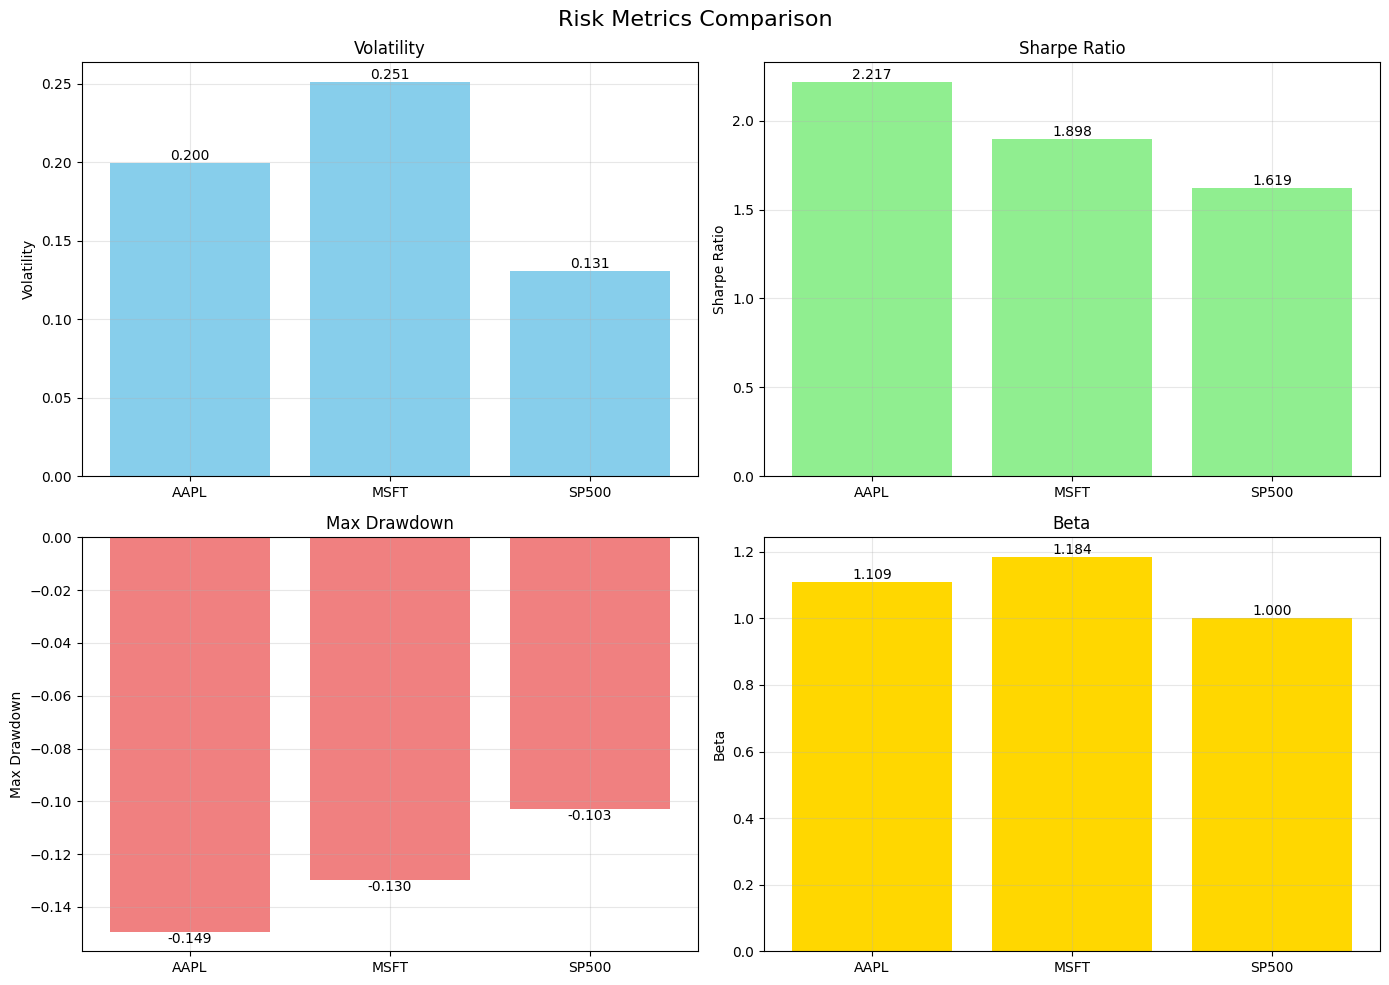

In [27]:
print("\n" + "="*50)
print("RISK METRICS CALCULATION")
print("="*50)

# Calculate additional risk metrics
risk_metrics = {}

for stock in ['AAPL', 'MSFT', 'SP500']:
    if stock in returns_for_plot.columns:
        returns = returns_for_plot[stock]
        
        if len(returns) > 1:  # Need at least 2 points for std dev
            # Annualized volatility (standard deviation × sqrt(252 trading days))
            volatility = returns.std() * np.sqrt(252) / 100  # Convert % to decimal
            
            # Sharpe Ratio (excess return per unit of risk)
            # Use annualized returns for Sharpe Ratio
            annual_return = returns.mean() * 252 / 100  # Convert % to decimal
            sharpe = (annual_return - risk_free_rate) / volatility if volatility > 0 else 0
            
            # Maximum Drawdown (worst peak-to-trough decline)
            cumulative = (1 + returns/100).cumprod()
            running_max = cumulative.expanding().max()
            drawdown = (cumulative - running_max) / running_max
            max_drawdown = drawdown.min() if len(drawdown) > 0 else 0
            
            # Sortino Ratio (only penalizes downside volatility)
            downside_returns = returns[returns < 0]
            downside_volatility = downside_returns.std() * np.sqrt(252) / 100 if len(downside_returns) > 1 else 0
            sortino = (annual_return - risk_free_rate) / downside_volatility if downside_volatility > 0 else 0
            
            risk_metrics[stock] = {
                'Volatility': volatility,
                'Sharpe Ratio': sharpe,
                'Sortino Ratio': sortino,
                'Max Drawdown': max_drawdown,
                'Beta': betas.get(stock, 1.0)  # Market has Beta = 1
            }
        else:
            print(f"Warning: Insufficient data for {stock} risk metrics")
    else:
        print(f"Warning: {stock} not in returns data")

# Create comparison dataframe
if risk_metrics:
    risk_df = pd.DataFrame(risk_metrics).T
    print("\nRisk Metrics Comparison:")
    print(risk_df.round(3))
    
    # Visualize risk-return tradeoff - FIXED VERSION
    try:
        fig = px.scatter(
            risk_df.reset_index(),
            x='Volatility',
            y='Sharpe Ratio',
            size='Beta',
            color='index',
            hover_name='index',
            hover_data=['Max Drawdown', 'Sortino Ratio'],
            title="Risk-Return Profile: Volatility vs Sharpe Ratio",
            labels={'index': 'Asset', 'Volatility': 'Annual Volatility'}
        )
        
        # Add market reference line (risk-free rate)
        fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
        
        fig.update_traces(marker=dict(line=dict(width=2, color='DarkSlateGrey')))
        fig.update_layout(template='plotly_white', height=500)
        
        # Display as static image
        print("\nDisplaying risk-return scatter plot as PNG...")
        fig.show(renderer="png")
        
        # Also save interactive version
        fig.write_html("risk_return_profile.html")
        print("✅ Interactive version saved as 'risk_return_profile.html'")
        
    except Exception as e:
        print(f"Could not create scatter plot: {e}")
        print("Showing risk metrics table instead:")
        print(risk_df)
    
    # Create a bar chart comparing key metrics
    try:
        fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
        fig2.suptitle('Risk Metrics Comparison', fontsize=16)

        metrics_to_plot = ['Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Beta']
        colors2 = ['skyblue', 'lightgreen', 'lightcoral', 'gold']

        for idx, metric in enumerate(metrics_to_plot):
            ax = axes2[idx//2, idx%2]
            if metric in risk_df.columns:
                values = risk_df[metric]
                assets = risk_df.index
                
                bars = ax.bar(assets, values, color=colors2[idx])
                ax.set_title(f'{metric}')
                ax.set_ylabel(metric)
                ax.grid(True, alpha=0.3)
                
                # Add value labels on bars
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                            f'{height:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
            else:
                ax.text(0.5, 0.5, f'No {metric} data', 
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{metric}')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create bar charts: {e}")
        
else:
    print("No risk metrics calculated - insufficient data")

### Risk Metrics Explained:

- Volatility: How much returns fluctuate (higher = riskier)
- Sharpe Ratio: Return per unit of total risk (higher = better)
- Sortino Ratio: Return per unit of downside risk (only penalizes negative volatility)
- Max Drawdown: Worst historical loss from peak to trough
- Beta: Sensitivity to market movements